# Title

# Description

In [1]:
# pip install category_encoders
# !pip install pmdarima

# Importation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
import os
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
train = pd.read_csv('../../assets/data/Train.csv')
sample = pd.read_csv('../../assets/data/SampleSubmission.csv')

# Dataset overview

In [4]:
train.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,5.0,11.0
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0


In [5]:
train.drop('start_time', axis=1, inplace=True)
train.drop('end_time', axis=1, inplace=True)

In [6]:
train['date'] = pd.to_datetime(train['date'])

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289926 entries, 0 to 289925
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   impressions         289526 non-null  float64       
 1   clicks              289526 non-null  float64       
 2   cost                289526 non-null  float64       
 3   conversions         289526 non-null  float64       
 4   ad_type             289526 non-null  object        
 5   currency            289526 non-null  object        
 6   ID                  289926 non-null  object        
 7   date                289926 non-null  datetime64[ns]
 8   call_type           36900 non-null   object        
 9   call_status         36900 non-null   object        
 10  duration            36900 non-null   float64       
 11  display_location    36900 non-null   object        
 12  impression_share    289926 non-null  float64       
 13  conversions_calls   280071 no

In [8]:
train.describe()

,impressions,clicks,cost,conversions,date,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
count,289526.000000,289526.000000,289526.000000,289526.000000,289926,36900.000000,289926.000000,280071.000000,289526.000000,289526.000000,289526.000000
mean,72.809620,8.039927,2208.525051,0.790140,2022-10-07 05:40:09.014714112,67.968970,16.656556,0.127928,2.745584,2.879824,10.706165
min,0.000000,0.000000,0.000000,0.000000,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,2022-02-04 00:00:00,0.000000,9.990000,0.000000,2.000000,1.000000,10.000000
50%,23.000000,2.000000,553.000000,0.000000,2022-11-13 00:00:00,36.000000,11.421975,0.000000,3.000000,3.000000,12.000000
75%,69.000000,6.000000,2062.500000,0.000000,2023-07-21 00:00:00,95.000000,20.122939,0.000000,4.000000,4.000000,14.000000
max,6833.000000,4227.000000,719928.000000,1297.000000,2024-02-13 00:00:00,2125.000000,100.000000,8.000000,7.000000,7.000000,20.000000
std,153.592792,36.241161,7392.609733,10.298258,NaN,98.055148,12.186418,0.526362,1.571108,1.670356,4.509450


In [9]:
numeric_columns = train.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
categoric_columns = [col for col in train.columns if col not in numeric_columns]
categoric_columns.remove('date')

In [10]:
for col in categoric_columns:
  print(col, len(train[col].unique()), train[col].unique())

ad_type 4 ['EXPANDED_TEXT_AD' 'EXPANDED_DYNAMIC_SEARCH_AD' 'RESPONSIVE_SEARCH_AD'
 nan]
currency 3 ['ZAR' 'USD' nan]
ID 185 ['ID_5da86e71bf5dee4cf5047046' 'ID_5e43c29e6279884e2827d894'
 'ID_5e4e7b480e374330ee151305' 'ID_5e8ad56cd4090270567b6c58'
 'ID_5e8b4f12d8709943490cd775' 'ID_5ebe73c4beb2212d415f6e56'
 'ID_5ee74f25f865a8154966b412' 'ID_5eebc5be7bcfa265595eb987'
 'ID_5f2ac3529666de2cdf5ae855' 'ID_5f3cdce8c0440e2c5902dd59'
 'ID_5f436d32c620230547446af4' 'ID_5f439a30fcc0f575b674bb95'
 'ID_5f4514323f494e4a2a5eb273' 'ID_5f9e5f1c691b48189c22aac6'
 'ID_5fa3dab4394cd16b000ec5fc' 'ID_5fc1263767e20c14590941ed'
 'ID_5fd88b10425b32098417a3d4' 'ID_600d8eaaf5c7660c0b1f0773'
 'ID_6017e410f7384a78e600da18' 'ID_602b729b3f4128452c1c2f64'
 'ID_602cfab1d7768d79aa6629b4' 'ID_604752a9861a02467a27c054'
 'ID_60475eaac98ea30d727b7385' 'ID_6047b0d4c59eff5af82a57ee'
 'ID_606f34aef59df516866d0ab1' 'ID_6083bd8472c70c3d1869bc68'
 'ID_608a6897d96a507cd36c935d' 'ID_608a6ad834a94a4eb8742899'
 'ID_60e556f789173d61d

## Hypothesis
**H0**: 

**H1**: 

## Questions

1. Is the train data complete?
2. Do we have seasonality in our ?
3. Are there outliers in our dataset?
4. What is the difference between RMSLE, RMSE and MSE?

| Issues                                  | how we intend to solve them                                                                                                   |
|----------------------------------------|------------------------------------------------------------------------------------------------------------|
| 1. date, start and end time column has wrong data type | convert to datetime                                            |
| 2. display_location has 'Ad' & 'AD' which are the same thing  | replace all 'Ad' with 'AD'                         |
| 2. issue 2 | soln2                         |


# Data Cleaning

Here, we will prepare our data for Univariate and Bivariate analysis.

## Fixing our issues

1. date column has wrong data type

In [11]:
train['date'] = pd.to_datetime(train['date'])

2. display_location column in train has values of 'Ad' & 'AD' which are the same thing  | replace all 'Ad' with 'AD' 

In [12]:
train['display_location'] = train['display_location'].replace('Ad', 'AD')

In [13]:
# make sure sorted by date
train = train.sort_values('date')

In [14]:
# create a function to check for missing extracted dates
def get_missing_dates(df):
  col = df.date
  missing_dates = (pd.date_range(

      start=col.min(), #start date
      end=col.max())   #end_date
      .difference(col))
  print(f"we have {len(missing_dates)} dates missing out of {len(col)}")
  print(f"start: {col.min()}, end: {col.max()}")
  return missing_dates
get_missing_dates(train)

we have 0 dates missing out of 289926
start: 2020-01-01 00:00:00, end: 2024-02-13 00:00:00


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

## Drop Duplicates

In [15]:
train.drop_duplicates(inplace=True)

## Impute Missing Values

In [16]:
print(train.isnull().sum())

impressions              400
clicks                   400
cost                     400
conversions              400
ad_type                  400
currency                 400
ID                         0
date                       0
call_type             252804
call_status           252804
duration              252804
display_location      252804
impression_share           0
conversions_calls       9841
headline1_len            400
headline2_len            400
ad_description_len       400
dtype: int64


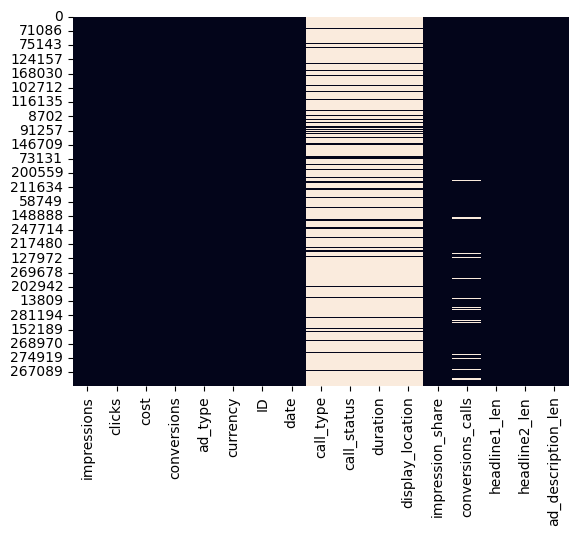

In [17]:
sns.heatmap(train.isnull(), cbar=False)
plt.show()

In [18]:
train = train.fillna(method='ffill')
train = train.fillna(method='bfill')

In [19]:
# train = train.interpolate(method ='linear') # limit_direction : {‘forward’, ‘backward’, ‘both’},
# train = train.interpolate(method ='time')
# train = train.interpolate(method ='slinear')
# train = train.interpolate(method ='spline')

# Exploratory Data Analysis: EDA

## Hypothesis Validation
**H0**: 

**H1**: 

## Answering Questions

2. Do we have seasonality in our sales?

In [20]:
# Assuming your time series data is stored in the variable 'sales_data'
sales_data = train['clicks']

In [21]:
# Perform KPSS test
kpss_result = kpss(sales_data)
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]

In [22]:
print("\nKPSS Test:")
print("KPSS Statistic:", kpss_statistic)
print("p-value:", kpss_pvalue)


KPSS Test:
KPSS Statistic: 16.044997950071174
p-value: 0.01


stationary if p-value > 0.05

series is stationary since 0.01 < 0.05

### Checking for Stationarity of the Train Dataset

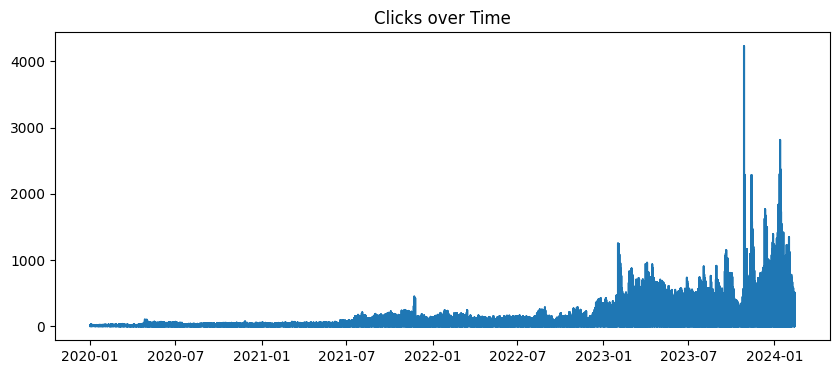

In [23]:
# Plot the series
plt.figure(figsize=(10,4))
plt.plot(train.set_index('date')['clicks'], linestyle='-')

plt.title('Clicks over Time')
# Show plot
plt.show()

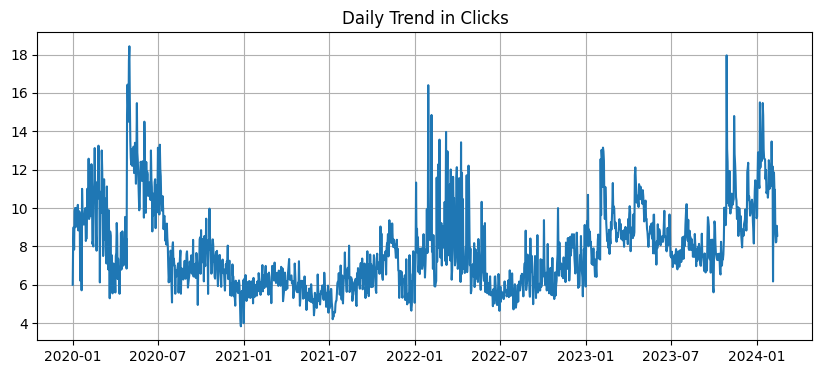

In [24]:
# Resample to monthly data and calculate the mean clicks per month
train_resampled = train.resample('D', on='date')['clicks'].mean()

# Plot the time series
plt.figure(figsize=(10, 4))
plt.plot(train_resampled, linestyle='-')  # Plot the resampled monthly clicks

# Add a title
plt.title('Daily Trend in Clicks')

# Show the plot
plt.grid(True)
plt.show()


there is no trend in our series

3. Are there outliers in our dataset?

4. What is the difference between RMSLE, RMSE and MSE?

## Univariate Analysis

## Bivariate Analysis

In [25]:
# Calculate the correlation matrix
correlation_matrix = train[numeric_columns].corr()

# Find the moderately correlated variables
moderate_correlation = (correlation_matrix.abs() > 0.5) & (correlation_matrix != 1) & (correlation_matrix <0.8)

# Get the variable pairs with moderate correlation
moderate_correlation_pairs = [(i, j) for i in moderate_correlation.columns for j in moderate_correlation.columns if moderate_correlation.loc[i, j]]

# Print the moderately correlated variables
for pair in moderate_correlation_pairs:
    var1, var2 = pair
    correlation_value = correlation_matrix.loc[var1, var2]
    print(f"{var1} and {var2} are moderately correlated (correlation value: {correlation_value})")

impressions and clicks are moderately correlated (correlation value: 0.7355471438009253)
clicks and impressions are moderately correlated (correlation value: 0.7355471438009253)
headline1_len and ad_description_len are moderately correlated (correlation value: 0.5839662592633951)
headline2_len and ad_description_len are moderately correlated (correlation value: 0.5525863512292191)
ad_description_len and headline1_len are moderately correlated (correlation value: 0.5839662592633951)
ad_description_len and headline2_len are moderately correlated (correlation value: 0.5525863512292191)


# Feature Engineering

## Creating New Features

In [26]:
# time since previous ad_secs
# ad_duration_secs 
# start_time_secs, end_time_secs

## Features Encoding & scaling

In [27]:
train.set_index('date', inplace=True)

In [28]:
cat_columns = ['ad_type','currency','ID','call_type','display_location','call_status']
num_columns = ['impressions','cost','conversions','duration','impression_share','conversions_calls','headline1_len','headline2_len','ad_description_len']

In [29]:
# create test_new df
sample_new = sample.drop('clicks', axis=1).copy()
# Step 1: Split 'ID' column into 'ID' and 'date'
sample_new['ID'] = sample['ID'].str[:-11]  
sample_new['date'] = sample['ID'].str[-10:]  

# Step 2: Create numeric columns and set their values to zero
sample_new[num_columns] = 0
sample_new

,ID,clicks,date,impressions,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,ID_5da86e71bf5dee4cf5047046,0,2024_01_22,0,0,0,0,0,0,0,0,0
1,ID_5da86e71bf5dee4cf5047046,0,2024_01_29,0,0,0,0,0,0,0,0,0
2,ID_5e43c29e6279884e2827d894,0,2024_02_21,0,0,0,0,0,0,0,0,0
3,ID_5e43c29e6279884e2827d894,0,2024_02_28,0,0,0,0,0,0,0,0,0
4,ID_5e4e7b480e374330ee151305,0,2023_12_04,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
365,ID_6568807cbb9c4d235c5dd9a8,0,2024_02_06,0,0,0,0,0,0,0,0,0
366,ID_65a7bf329fa4627faf28390c,0,2024_02_21,0,0,0,0,0,0,0,0,0
367,ID_65a7bf329fa4627faf28390c,0,2024_02_28,0,0,0,0,0,0,0,0,0
368,ID_65b0f65c7fe62e56c5593d55,0,2024_02_21,0,0,0,0,0,0,0,0,0


In [30]:
# Step 3: Create categorical columns and set their values randomly from 'train'
for col in cat_columns:
    sample_new[col] = np.random.choice(train[col].unique(), size=len(sample_new))

# Now 'sample_new' DataFrame has been modified as 'test_new'
test_new = sample_new
test_new

,ID,clicks,date,impressions,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,ad_type,currency,call_type,display_location,call_status
0,ID_64a5c7e0db50245803503dd7,0,2024_01_22,0,0,0,0,0,0,0,0,0,EXPANDED_TEXT_AD,USD,Mobile click-to-call,Website,Missed
1,ID_5eebc5be7bcfa265595eb987,0,2024_01_29,0,0,0,0,0,0,0,0,0,EXPANDED_TEXT_AD,ZAR,Mobile click-to-call,Website,Missed
2,ID_637cf28cab15af520049256a,0,2024_02_21,0,0,0,0,0,0,0,0,0,EXPANDED_TEXT_AD,ZAR,Mobile click-to-call,AD,Missed
3,ID_6540ddc07e6887217043b524,0,2024_02_28,0,0,0,0,0,0,0,0,0,EXPANDED_TEXT_AD,ZAR,Manually dialed,LANDING_PAGE,Received
4,ID_618a6797e203d8234e6856dd,0,2023_12_04,0,0,0,0,0,0,0,0,0,EXPANDED_DYNAMIC_SEARCH_AD,USD,Mobile click-to-call,AD,Received
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,ID_60e5572b44311c0aa4513107,0,2024_02_06,0,0,0,0,0,0,0,0,0,RESPONSIVE_SEARCH_AD,ZAR,Mobile click-to-call,Website,Missed
366,ID_649ecc31c986241e700a2046,0,2024_02_21,0,0,0,0,0,0,0,0,0,RESPONSIVE_SEARCH_AD,USD,Manually dialed,LANDING_PAGE,Received
367,ID_60ed537e880be55ca17d2cb6,0,2024_02_28,0,0,0,0,0,0,0,0,0,RESPONSIVE_SEARCH_AD,USD,Mobile click-to-call,Website,Missed
368,ID_6512f45aa0d0733bf951e3c5,0,2024_02_21,0,0,0,0,0,0,0,0,0,EXPANDED_DYNAMIC_SEARCH_AD,USD,Mobile click-to-call,AD,Received


In [31]:
# categoric_columns.remove('ID')
# # Resample numerical columns by daily sum
# resampled_numerical = train[numeric_columns].resample('D').sum()

# # Find the most frequent category for each categorical column for each day
# resampled_categorical = pd.concat([train[col].resample('D').agg(lambda x: x.value_counts().idxmax() if len(x.value_counts()) else None) for col in categoric_columns], axis=1)

# # Concatenate numerical and categorical resampled DataFrames
# resampled_train = pd.concat([resampled_numerical, resampled_categorical], axis=1)

# # Reset index to make 'date' a column again
# # resampled_train.reset_index(inplace=True)
# categoric_columns.append('ID')
# train = resampled_train
# resampled_train

In [32]:
for col in categoric_columns:
  print(col, len(train[col].unique()), train[col].unique())

ad_type 3 ['EXPANDED_TEXT_AD' 'EXPANDED_DYNAMIC_SEARCH_AD' 'RESPONSIVE_SEARCH_AD']
currency 2 ['ZAR' 'USD']
ID 185 ['ID_5da86e71bf5dee4cf5047046' 'ID_5e43c29e6279884e2827d894'
 'ID_5e4e7b480e374330ee151305' 'ID_5e8b4f12d8709943490cd775'
 'ID_5e8ad56cd4090270567b6c58' 'ID_5ebe73c4beb2212d415f6e56'
 'ID_5eebc5be7bcfa265595eb987' 'ID_5ee74f25f865a8154966b412'
 'ID_5f2ac3529666de2cdf5ae855' 'ID_5f439a30fcc0f575b674bb95'
 'ID_5f436d32c620230547446af4' 'ID_5f4514323f494e4a2a5eb273'
 'ID_5f3cdce8c0440e2c5902dd59' 'ID_5f9e5f1c691b48189c22aac6'
 'ID_5fa3dab4394cd16b000ec5fc' 'ID_5fd88b10425b32098417a3d4'
 'ID_600d8eaaf5c7660c0b1f0773' 'ID_6017e410f7384a78e600da18'
 'ID_602b729b3f4128452c1c2f64' 'ID_602cfab1d7768d79aa6629b4'
 'ID_60475eaac98ea30d727b7385' 'ID_604752a9861a02467a27c054'
 'ID_6047b0d4c59eff5af82a57ee' 'ID_606f34aef59df516866d0ab1'
 'ID_6083bd8472c70c3d1869bc68' 'ID_608a6897d96a507cd36c935d'
 'ID_608a6ad834a94a4eb8742899' 'ID_60e556f789173d61d07e3294'
 'ID_60e5572b44311c0aa4513107' 

In [33]:
train['call_status'] = train['call_status'].map({'Missed': 0, 'Received': 1})

In [34]:
categoric_columns.remove('call_status')
# categoric_columns.remove('ID')
numeric_columns.remove('clicks')

In [35]:
encoder = BinaryEncoder(drop_invariant=False, return_df=True,)
IDs_encoded = encoder.fit_transform(train['ID'])

In [36]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.set_output(transform="pandas")
scaler = StandardScaler().set_output(transform="pandas")

In [37]:
scaled_num = scaler.fit_transform(train[numeric_columns])
encoded_cat = encoder.fit_transform(train[categoric_columns])

In [38]:
# train = pd.concat([IDs_encoded, scaled_num, encoded_cat, train['call_status'], train['clicks']], axis=1)
train = pd.concat([scaled_num, encoded_cat, train['call_status'], train['clicks']], axis=1)

In [39]:
train.shape

(287399, 206)

In [40]:
train.head()

,impressions,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,ad_type_EXPANDED_DYNAMIC_SEARCH_AD,...,ID_ID_6568807cbb9c4d235c5dd9a8,ID_ID_65a7bf329fa4627faf28390c,ID_ID_65b0f65c7fe62e56c5593d55,call_type_Manually dialed,call_type_Mobile click-to-call,display_location_AD,display_location_LANDING_PAGE,display_location_Website,call_status,clicks
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.458624,0.162160,-0.073501,-0.715692,-0.029394,-0.236872,-0.473641,1.269368,0.065773,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,15.0
2020-01-01,0.110750,-0.050965,-0.073501,-0.715692,-0.029394,-0.236872,-0.473641,-0.528306,0.509009,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,8.0
2020-01-01,-0.086160,-0.060973,-0.073501,-0.715692,-0.029394,-0.236872,-0.473641,-0.528306,-0.155845,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,8.0
2020-01-01,0.038550,-0.172674,-0.073501,-0.715692,-0.029394,-0.236872,-0.473641,0.070919,0.509009,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,4.0
2020-01-01,-0.342142,-0.267336,-0.073501,-0.715692,-0.029394,-0.236872,-0.473641,-0.528306,0.509009,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1.0


## Resampling

In [41]:
# resampled = train.resample('D').sum()
# # train = resampled

**dataframe for the traditional time series models**

In [42]:
# train1 = train[['target']].copy()

In [43]:
# train1.head()

In [44]:
test, train_df  = train[len(train)-15:], train[:len(train)-15] # or 4000 for unresampled
test.reset_index().date.min() # 2024-01-30

Timestamp('2024-02-13 00:00:00')

In [45]:
eval, train  = train_df[len(train_df)-15:], train_df[:len(train_df)-15]
eval.reset_index().date.min() # 2024-01-30

Timestamp('2024-02-13 00:00:00')

In [46]:
# Split data into parts
X_train, X_test, y_train, y_test = train.drop(['clicks'], axis=1), eval.drop(['clicks'], axis=1), train['clicks'], eval['clicks']

# Machine Learning Modeling

# Non-Traditional Time Series Models

### DecisionTreeRegressor

In [47]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
model_tree = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_tree.predict(X_test)

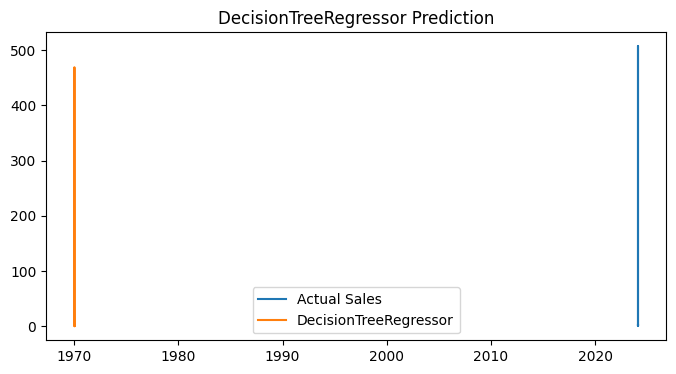

In [48]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(tree_pred, label='DecisionTreeRegressor')
plt.legend(loc='best')
plt.title('DecisionTreeRegressor Prediction')
plt.show()

In [49]:
mse = mean_squared_error(y_test, tree_pred )
rmse = np.sqrt(mean_squared_error(y_test, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)
msle = mean_squared_log_error(y_test, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

### KNN

In [50]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

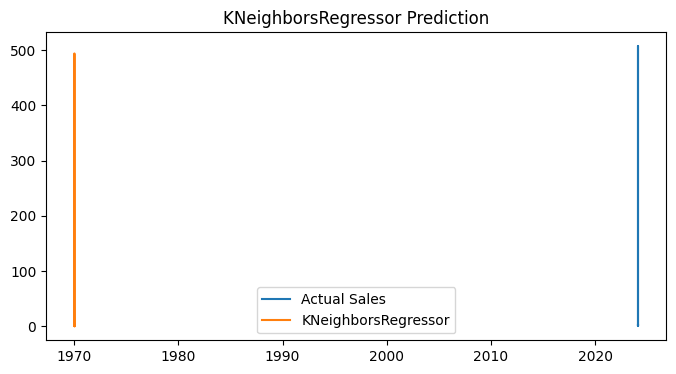

In [51]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(neigh_pred, label='KNeighborsRegressor')
plt.legend(loc='best')
plt.title('KNeighborsRegressor Prediction')
plt.show()

In [52]:
mse = mean_squared_error(y_test, neigh_pred )
msle = mean_squared_log_error(y_test, neigh_pred)
rmse = np.sqrt(mean_squared_error(y_test, neigh_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
model_results = pd.DataFrame([['KNN', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# Concatenating the two DataFrames
results = pd.concat([results, model_results], ignore_index=True)

In [53]:
results

,Model,MSE,MSLE,RMSE,RMSLE
0,DecisionTree,148.266667,0.080000,12.18,0.29000
1,KNN,63.200000,0.183463,7.95,0.42833


### RandomForestRegressor

In [54]:
# from sklearn.ensemble import RandomForestRegressor
# # Initialize and fit the Random Forest Regressor
# forest = RandomForestRegressor()
# model_forest = forest.fit(X_train, y_train)

# # Make predictions on X_test
# forest_pred = model_forest.predict(X_test)

In [55]:
# plt.figure(figsize=(8, 4))
# plt.plot(y_test, label='Actual Sales')
# plt.plot(forest_pred, label='RandomForestRegressor')
# plt.legend(loc='best')
# plt.title('RandomForestRegressor Prediction')
# plt.show()

In [56]:
# mse = mean_squared_error(y_test, forest_pred)
# msle = mean_squared_log_error(y_test, forest_pred)
# rmse = np.sqrt(mse).round(2)
# rmsle = np.sqrt(msle).round(5)

# # Append the results to the DataFrame
# model_results = pd.DataFrame([['Random Forest', mse, msle, rmse, rmsle]],
#                              columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = pd.concat([results, model_results], ignore_index=True)

### Support Vector Regression (SVR)

In [57]:
# from sklearn.svm import SVR

# # Initialize and fit the SVR model
# svr = SVR()
# model_svr = svr.fit(X_train, y_train)

# # Make predictions on X_test
# svr_pred = model_svr.predict(X_test)

In [58]:
# plt.figure(figsize=(8, 4))
# plt.plot(y_test, label='Actual Sales')
# plt.plot(svr_pred, label='Support Vector Regression')
# plt.legend(loc='best')
# plt.title('Support Vector Regression Prediction')
# plt.show()

In [59]:
# # Append the results to the DataFrame
# mse = mean_squared_error(y_test, svr_pred)
# msle = mean_squared_log_error(y_test, svr_pred)
# rmse = np.sqrt(mse).round(2)
# rmsle = np.sqrt(msle).round(5)

# model_results = pd.DataFrame([['SVR', mse, msle, rmse, rmsle]],
#                              columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = pd.concat([results, model_results], ignore_index=True)

### Gradient Boosting

In [60]:
# from sklearn.ensemble import GradientBoostingRegressor

# # Initialize and fit the Gradient Boosting model
# gbr = GradientBoostingRegressor()
# model_gbr = gbr.fit(X_train, y_train)

# # Make predictions on X_test
# gbr_pred = model_gbr.predict(X_test)

In [61]:
# plt.figure(figsize=(8, 4))
# plt.plot(y_test, label='Actual Sales')
# plt.plot(gbr_pred, label='Gradient Boosting')
# plt.legend(loc='best')
# plt.title('Gradient Boosting Prediction')
# plt.show()

In [62]:
# # Append the results to the DataFrame
# mse = mean_squared_error(y_test, gbr_pred)
# msle = mean_squared_log_error(y_test, gbr_pred)
# rmse = np.sqrt(mse).round(2)
# rmsle = np.sqrt(msle).round(5)

# model_results = pd.DataFrame([['Gradient Boosting', mse, msle, rmse, rmsle]],
#                              columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = pd.concat([results, model_results], ignore_index=True)

### XGBoost

In [63]:
# import xgboost as xgb

# # Initialize and fit the XGBoost model
# xgboost = xgb.XGBRegressor()
# model_xgboost = xgboost.fit(X_train, y_train)

# # Make predictions on X_test
# xgboost_pred = model_xgboost.predict(X_test)

# # Append the results to the DataFrame
# mse = mean_squared_error(y_test, xgboost_pred)
# msle = mean_squared_log_error(y_test, xgboost_pred)
# rmse = np.sqrt(mse).round(2)
# rmsle = np.sqrt(msle).round(5)

# model_results = pd.DataFrame([['XGBoost', mse, msle, rmse, rmsle]],
#                              columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = pd.concat([results, model_results], ignore_index=True)

### Linear Regression

In [64]:
# from sklearn.linear_model import LinearRegression

# # Initialize and fit the Linear Regression model
# linear_reg = LinearRegression()
# model_linear_reg = linear_reg.fit(X_train, y_train)

# # Make predictions on X_test
# linear_reg_pred = model_linear_reg.predict(X_test)

# # Append the results to the DataFrame
# mse = mean_squared_error(y_test, linear_reg_pred)
# msle = mean_squared_log_error(y_test, linear_reg_pred)
# rmse = np.sqrt(mse).round(2)
# rmsle = np.sqrt(msle).round(5)

# model_results = pd.DataFrame([['Linear Regression', mse, msle, rmse, rmsle]],
#                              columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = pd.concat([results, model_results], ignore_index=True)

## Models Comparison

In [65]:
results

,Model,MSE,MSLE,RMSE,RMSLE
0,DecisionTree,148.266667,0.080000,12.18,0.29000
1,KNN,63.200000,0.183463,7.95,0.42833


## Model Evaluation (test)

In [66]:
X_test = test.drop(['clicks'], axis=1)
y_test = test['clicks']

best_model = neigh
test_pred = best_model.predict(X_test)

# Append the results to the DataFrame
mse = mean_squared_error(y_test, test_pred)
msle = mean_squared_log_error(y_test, test_pred)
rmse = np.sqrt(mse).round(2)
rmsle = np.sqrt(msle).round(5)

results = pd.DataFrame([['best_model', mse, msle, rmse, rmsle]],
                             columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,best_model,3.466667,0.03846,1.86,0.19611


# Hyperparameter Tuning

### predicting sales in our test

In [68]:
test_new.head()

,ID,clicks,date,impressions,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,ad_type,currency,call_type,display_location,call_status
0,ID_64a5c7e0db50245803503dd7,0,2024_01_22,0,0,0,0,0,0,0,0,0,EXPANDED_TEXT_AD,USD,Mobile click-to-call,Website,Missed
1,ID_5eebc5be7bcfa265595eb987,0,2024_01_29,0,0,0,0,0,0,0,0,0,EXPANDED_TEXT_AD,ZAR,Mobile click-to-call,Website,Missed
2,ID_637cf28cab15af520049256a,0,2024_02_21,0,0,0,0,0,0,0,0,0,EXPANDED_TEXT_AD,ZAR,Mobile click-to-call,AD,Missed
3,ID_6540ddc07e6887217043b524,0,2024_02_28,0,0,0,0,0,0,0,0,0,EXPANDED_TEXT_AD,ZAR,Manually dialed,LANDING_PAGE,Received
4,ID_618a6797e203d8234e6856dd,0,2023_12_04,0,0,0,0,0,0,0,0,0,EXPANDED_DYNAMIC_SEARCH_AD,USD,Mobile click-to-call,AD,Received


In [69]:
test_new['date'] = pd.to_datetime(test_new['date'], format='%Y_%m_%d')
test_new.set_index('date', inplace=True)

In [70]:
test_new['call_status'] = test_new['call_status'].map({'Missed': 0, 'Received': 1})
scaled_num = scaler.fit_transform(test_new[numeric_columns])
encoded_cat = encoder.fit_transform(test_new[categoric_columns])
test_new = pd.concat([scaled_num, encoded_cat, test_new['call_status']], axis=1)

In [71]:
from IPython.core.display import display

# Set max column width to None to display full contents of columns
pd.set_option('display.max_colwidth', None)

# Set max rows and columns to None to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# Now, when you print dataframes or any other output, it should display the full content


In [72]:
test_new.head(1)

,impressions,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,ad_type_EXPANDED_DYNAMIC_SEARCH_AD,ad_type_EXPANDED_TEXT_AD,ad_type_RESPONSIVE_SEARCH_AD,currency_USD,currency_ZAR,ID_ID_5da86e71bf5dee4cf5047046,ID_ID_5e43c29e6279884e2827d894,ID_ID_5e4e7b480e374330ee151305,ID_ID_5e8ad56cd4090270567b6c58,ID_ID_5e8b4f12d8709943490cd775,ID_ID_5eebc5be7bcfa265595eb987,ID_ID_5f2ac3529666de2cdf5ae855,ID_ID_5f3cdce8c0440e2c5902dd59,ID_ID_5f436d32c620230547446af4,ID_ID_5f439a30fcc0f575b674bb95,ID_ID_5f4514323f494e4a2a5eb273,ID_ID_5fc1263767e20c14590941ed,ID_ID_600d8eaaf5c7660c0b1f0773,ID_ID_6017e410f7384a78e600da18,ID_ID_602b729b3f4128452c1c2f64,ID_ID_602cfab1d7768d79aa6629b4,ID_ID_60475eaac98ea30d727b7385,ID_ID_6047b0d4c59eff5af82a57ee,ID_ID_606f34aef59df516866d0ab1,ID_ID_6083bd8472c70c3d1869bc68,ID_ID_608a6897d96a507cd36c935d,ID_ID_608a6ad834a94a4eb8742899,ID_ID_60e556f789173d61d07e3294,ID_ID_60e5572b44311c0aa4513107,ID_ID_60ed537e880be55ca17d2cb6,ID_ID_60f0802ede929401f94e50b5,ID_ID_60f12ace56214677d611d526,ID_ID_60ffd129e838871b1754c836,ID_ID_6103b50cd6d4a602e4370f05,ID_ID_6127aa3ad0a7b71b7b70196c,ID_ID_6130ea7a06c5cb5b571f8c1d,ID_ID_613716cf75986166a63686d7,ID_ID_6141dbc4d1a65a3c9165cb24,ID_ID_6141e46e3492111e0c6d2a34,ID_ID_6163e3ed2c87b93c6055ec2a,ID_ID_617beb7403c1051f8a42b524,ID_ID_618a50e0500d9413097ccd75,ID_ID_618a6797e203d8234e6856dd,ID_ID_619b545521ae9a187f0f0d97,ID_ID_619caa6d230440455a384bf6,ID_ID_61ab912923980748d20c8fd8,ID_ID_61dc323a202ecc233d4dabb5,ID_ID_61efa4189f0e4645b652296a,ID_ID_61f2910d076b173c5c629945,ID_ID_61f96ef9941a217657673f65,ID_ID_620fa2fa329e60259f7ddec6,ID_ID_62123b0e0c4f78309f3d8ac6,ID_ID_6242e6f147af795a92470368,ID_ID_624bfadac86f51149f3fbde5,ID_ID_6255767a2a9dd71a6713a095,ID_ID_62713c09ca26da4db1116a05,ID_ID_6273ad211040cf53e66b4bf8,ID_ID_6273d3a2b67ccf3b406068a5,ID_ID_62791a704acc5b2736563535,ID_ID_628cfb8dd9689515112d48c6,ID_ID_6298b6310def91542a5752f4,ID_ID_629e729214035d4a8541e0b8,ID_ID_62a1db369df50737b3321a67,ID_ID_62a35b4a56776675c40646a7,ID_ID_62f948a0e9c85b405b795005,ID_ID_630cb29cb4633d70ec3e4b28,ID_ID_6320507deb37f91b900fe6e4,ID_ID_632c2af9bec9c87e603107b6,ID_ID_63340f02a7363d4b2c0ae32a,ID_ID_6335a2838ac3337afb26d4d7,ID_ID_6356bad61ebba975f01f5425,ID_ID_6361f9ffedd8353ed336f745,ID_ID_636b2ffdba11153d7f4f2c06,ID_ID_637b6db8e47f4c3b177caf24,ID_ID_637cf28cab15af520049256a,ID_ID_6384b57da130a026dd715854,ID_ID_6388a9cc4d7af753062f0529,ID_ID_63964ba81a9885127837fbc7,ID_ID_63c12db6fa571b3a613d43a4,ID_ID_63d27db626e7ad79b7640c46,ID_ID_63e4ac66c90a346ba96ed7c6,ID_ID_63fc719f9bf744526a195e98,ID_ID_64070e48bd7071708438f398,ID_ID_64073fc37d61047ad161a606,ID_ID_6408bea7943d11680870ef37,ID_ID_64268025a80ef266c3417e27,ID_ID_6426c145b53c89172029f506,ID_ID_643e64bd9190740c1d7407f6,ID_ID_644b88421b452a7ea24bcd06,ID_ID_644bb63b02f7105d212ae969,ID_ID_645882d15227d476196aed49,ID_ID_645c94036caf5c77fe3a6151,ID_ID_6474d400c6933e4b4a5c5337,ID_ID_64771047e86c54306139f3c4,ID_ID_647dd041ce4cdb1a31597888,ID_ID_64818f74ee9ced578f40a9e6,ID_ID_6489889191a15a7fca16e326,ID_ID_649011d41e41763cc27f09b6,ID_ID_6491a50ce7b72a70aa75437a,ID_ID_6492ce879e3baf373a55aab5,ID_ID_6497597d8041b3133a721ec7,ID_ID_649964e26db1286c56156c66,ID_ID_6499963984bc60653a3e4495,ID_ID_649b37ba66eba1605b485d16,ID_ID_649ecc31c986241e700a2046,ID_ID_649ecd7cf95051327b338684,ID_ID_649f1bef6b4c6341ca18a0d5,ID_ID_649f3100b29ced7f6517a532,ID_ID_64a54c4b10409330e5559677,ID_ID_64a5c7e0db50245803503dd7,ID_ID_64ad4454fe7c2d69f25d9759,ID_ID_64b144b6bb5ebd59995098f8,ID_ID_64b6a2e5ec8e2640b008dad3,ID_ID_64b7b2795e6fd83b270de6b8,ID_ID_64b91852366a244c4c2d2616,ID_ID_64be5c51a5db0060046fa166,ID_ID_64c10bff5ae80900c97308a6,ID_ID_64c25df64807d0282706b0ca,ID_ID_64c29c0fb5fe0828b84b95f7,ID_ID_64c38b7d039d2322ec105c6a,ID_ID_64c393edb0613d10ec5ead4e,ID_ID_64c75a2e3f7a615b7d5161d8,ID_ID_64cce13a065233199d450754,ID_ID_64d0bd0091caf6305e343d81,ID_ID_64db339427687379bb7abc99,ID_ID_64dcd1614e8f73143e557db7,ID_ID_64e7594

In [73]:
test.head(1)

,impressions,cost,conversions,duration,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,ad_type_EXPANDED_DYNAMIC_SEARCH_AD,ad_type_EXPANDED_TEXT_AD,ad_type_RESPONSIVE_SEARCH_AD,currency_USD,currency_ZAR,ID_ID_5da86e71bf5dee4cf5047046,ID_ID_5e43c29e6279884e2827d894,ID_ID_5e4e7b480e374330ee151305,ID_ID_5e8ad56cd4090270567b6c58,ID_ID_5e8b4f12d8709943490cd775,ID_ID_5ebe73c4beb2212d415f6e56,ID_ID_5ee74f25f865a8154966b412,ID_ID_5eebc5be7bcfa265595eb987,ID_ID_5f2ac3529666de2cdf5ae855,ID_ID_5f3cdce8c0440e2c5902dd59,ID_ID_5f436d32c620230547446af4,ID_ID_5f439a30fcc0f575b674bb95,ID_ID_5f4514323f494e4a2a5eb273,ID_ID_5f9e5f1c691b48189c22aac6,ID_ID_5fa3dab4394cd16b000ec5fc,ID_ID_5fc1263767e20c14590941ed,ID_ID_5fd88b10425b32098417a3d4,ID_ID_600d8eaaf5c7660c0b1f0773,ID_ID_6017e410f7384a78e600da18,ID_ID_602b729b3f4128452c1c2f64,ID_ID_602cfab1d7768d79aa6629b4,ID_ID_604752a9861a02467a27c054,ID_ID_60475eaac98ea30d727b7385,ID_ID_6047b0d4c59eff5af82a57ee,ID_ID_606f34aef59df516866d0ab1,ID_ID_6083bd8472c70c3d1869bc68,ID_ID_608a6897d96a507cd36c935d,ID_ID_608a6ad834a94a4eb8742899,ID_ID_60e556f789173d61d07e3294,ID_ID_60e5572b44311c0aa4513107,ID_ID_60ed537e880be55ca17d2cb6,ID_ID_60f0802ede929401f94e50b5,ID_ID_60f12ace56214677d611d526,ID_ID_60ffd129e838871b1754c836,ID_ID_6103b50cd6d4a602e4370f05,ID_ID_6127aa3ad0a7b71b7b70196c,ID_ID_6130ea7a06c5cb5b571f8c1d,ID_ID_61321c129a9b4c145436394d,ID_ID_613716cf75986166a63686d7,ID_ID_6141dbc4d1a65a3c9165cb24,ID_ID_6141e46e3492111e0c6d2a34,ID_ID_6163e3ed2c87b93c6055ec2a,ID_ID_617beb7403c1051f8a42b524,ID_ID_618a50e0500d9413097ccd75,ID_ID_618a6797e203d8234e6856dd,ID_ID_619b545521ae9a187f0f0d97,ID_ID_619caa6d230440455a384bf6,ID_ID_61ab912923980748d20c8fd8,ID_ID_61d5c833cb67550b4d1f5008,ID_ID_61dc323a202ecc233d4dabb5,ID_ID_61efa4189f0e4645b652296a,ID_ID_61f27201f7db923685712128,ID_ID_61f2910d076b173c5c629945,ID_ID_61f96ef9941a217657673f65,ID_ID_620fa2fa329e60259f7ddec6,ID_ID_62123b0e0c4f78309f3d8ac6,ID_ID_621cbd298d435840264f9a22,ID_ID_6242e6f147af795a92470368,ID_ID_624bfadac86f51149f3fbde5,ID_ID_6255767a2a9dd71a6713a095,ID_ID_62713c09ca26da4db1116a05,ID_ID_6273ad211040cf53e66b4bf8,ID_ID_6273d3a2b67ccf3b406068a5,ID_ID_62791a704acc5b2736563535,ID_ID_627cb73e65f34e61fb4d3247,ID_ID_628cfb8dd9689515112d48c6,ID_ID_6298b6310def91542a5752f4,ID_ID_629e729214035d4a8541e0b8,ID_ID_62a03c6d638c217d405a9155,ID_ID_62a1a11ea8775f127917c026,ID_ID_62a1db369df50737b3321a67,ID_ID_62a35b4a56776675c40646a7,ID_ID_62f948a0e9c85b405b795005,ID_ID_630cb29cb4633d70ec3e4b28,ID_ID_6311c8df6a4fec36e3730ee5,ID_ID_6320507deb37f91b900fe6e4,ID_ID_632c2af9bec9c87e603107b6,ID_ID_63340f02a7363d4b2c0ae32a,ID_ID_6335a2838ac3337afb26d4d7,ID_ID_6356bad61ebba975f01f5425,ID_ID_6361f9ffedd8353ed336f745,ID_ID_636b2ffdba11153d7f4f2c06,ID_ID_637b6db8e47f4c3b177caf24,ID_ID_637c6b3c7aff7b47021ab16d,ID_ID_637cf28cab15af520049256a,ID_ID_6384b57da130a026dd715854,ID_ID_638610848693b868d47d4598,ID_ID_6388a9cc4d7af753062f0529,ID_ID_638f03cbed07d3161a77e484,ID_ID_63964ba81a9885127837fbc7,ID_ID_63b3b2bf9cd0314f465f8744,ID_ID_63b9b0b2c9469055e502b295,ID_ID_63c12db6fa571b3a613d43a4,ID_ID_63d27db626e7ad79b7640c46,ID_ID_63d8f018725833509b4a2c75,ID_ID_63e4ac66c90a346ba96ed7c6,ID_ID_63fc719f9bf744526a195e98,ID_ID_64070e48bd7071708438f398,ID_ID_64073fc37d61047ad161a606,ID_ID_6408bea7943d11680870ef37,ID_ID_64268025a80ef266c3417e27,ID_ID_6426c145b53c89172029f506,ID_ID_643e64bd9190740c1d7407f6,ID_ID_644b88421b452a7ea24bcd06,ID_ID_644bb63b02f7105d212ae969,ID_ID_645882d15227d476196aed49,ID_ID_6458d7b43d5a613f71410375,ID_ID_645c94036caf5c77fe3a6151,ID_ID_6464ba7988f2ff57157322b6,ID_ID_64676b314a2da50efd690a46,ID_ID_6474d400c6933e4b4a5c5337,ID_ID_64771047e86c54306139f3c4,ID_ID_647dd041ce4cdb1a31597888,ID_ID_64818f74ee9ced578f40a9e6,ID_ID_6489889191a15a7fca16e326,ID_ID_6489a3b64f5e7d5d110bd4eb,ID_ID_649011d41e41763cc27f09b6,ID_ID_6491a50ce7b72a70aa75437a,ID_ID_6492ce879e3baf373a55aab5,ID_ID_6497597d8041b3133a721ec7,ID_ID_649964e26db1286c56156c66,ID_ID_6499963

In [74]:
cols = 

for col in cols:
    test_new[col] = 0

In [75]:
test_pred = neigh.predict(test_new)
test_pred

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ID_5da86e71bf5dee4cf5047046
- ID_60475eaac98ea30d727b7385
- ID_60e5572b44311c0aa4513107
- ID_60ed537e880be55ca17d2cb6
- ID_61321c129a9b4c145436394d
Feature names seen at fit time, yet now missing:
- ID_ID_5ebe73c4beb2212d415f6e56
- ID_ID_5ee74f25f865a8154966b412
- ID_ID_5f9e5f1c691b48189c22aac6
- ID_ID_5fa3dab4394cd16b000ec5fc
- ID_ID_5fd88b10425b32098417a3d4
- ...


In [ ]:
test.head()

,onpromotion,is_holiday,year,month,dayofmonth,dayofweek,dayofyear,weekofyear,quarter,is_month_start,...,cluster_1,cluster_2,cluster_3,cluster_4,holiday_type_0,holiday_type_1,holiday_type_2,season_0,season_1,season_2
date_extracted,,,,,,,,,,,,,,,,,,,,,
2004-06-20,6.59,0.00,4.00,6.00,19.50,0.50,170.50,25.00,2.00,0.00,...,0.43,0.37,0.48,0.57,0.00,1.00,0.00,0.00,1.00,1.00
2004-06-27,8.01,0.29,4.00,6.00,24.00,3.00,175.00,25.29,2.00,0.00,...,0.43,0.37,0.48,0.57,0.00,0.71,0.29,0.00,1.00,1.00
2004-07-04,8.49,0.14,4.00,6.57,13.86,3.00,182.00,26.29,2.57,0.14,...,0.43,0.37,0.48,0.57,0.00,0.86,0.14,0.00,1.00,1.00
2004-07-11,8.75,0.00,4.00,7.00,8.00,3.00,189.00,27.29,3.00,0.00,...,0.43,0.37,0.48,0.57,0.00,1.00,0.00,0.00,1.00,1.00
2004-07-18,7.33,0.00,4.00,7.00,15.00,3.00,196.00,28.29,3.00,0.00,...,0.43,0.37,0.48,0.57,0.00,1.00,0.00,0.00,1.00,1.00


In [ ]:
# test['target'] = test_pred
# sub = test[['ID', 'target']]

In [ ]:
# Save sample submission
# sub.to_csv('submission.csv', index=False)